# SARIMA for Timeseries Forecasting
R is a strong language for performing statistical analysis, such as timeseries forecasting. In this notebook, we will attempt to predict the weather using SARIMA, a powerful statistical model for forecasting time series data with seasonal cycles and trends.

In [1]:
# Install required packages if not already installed
if (!require("forecast")) {
    install.packages("forecast", repos = "https://cran.rstudio.com/")
}
if (!require("tseries")) {
    install.packages("tseries", repos = "https://cran.rstudio.com/")
}
if (!require("ggplot2")) {
    install.packages("ggplot2", repos = "https://cran.rstudio.com/")
}
if (!require("lubridate")) {
    install.packages("lubridate", repos = "https://cran.rstudio.com/")
}
if (!require("dplyr")) {
    install.packages("dplyr", repos = "https://cran.rstudio.com/")
}

Loading required package: forecast

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: tseries

Loading required package: ggplot2

Loading required package: lubridate


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
library(forecast)
library(tseries)
library(ggplot2)
library(lubridate)
library(dplyr)

In [3]:
df <- read.csv("jena_climate_2009_2016.csv")
colnames(df)
head(df)

[1] "X0" "X1" "X2" "X3" "X4" "X5" "X6"

,X0,X1,X2,X3,X4,X5,X6
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.9554511,-2.000020,-1.319782,-0.7884790,-1.500927,2.237658,-0.7329972
2,0.9615279,-2.045185,-1.332806,-0.7905606,-1.519521,2.287838,-0.9360023
3,0.9566665,-2.056766,-1.335410,-0.7926422,-1.523239,2.298608,-1.2830756
4,0.9542358,-2.033604,-1.328898,-0.7947239,-1.508364,2.272906,-1.1848473
5,0.9542358,-2.028972,-1.327596,-0.7947239,-1.508364,2.268256,-1.1979444
6,0.9530204,-2.003494,-1.319782,-0.7947239,-1.493489,2.240351,-1.2699785


In [4]:
nrow(df)


[1] 420551

In [5]:
# Aggregate 10-minute data to hourly data
# Create datetime sequence starting from 2009-01-01, every 10 minutes
start_date <- as.POSIXct("2009-01-01 00:00:00", tz = "UTC")
df$datetime <- start_date + (0:(nrow(df)-1)) * 600  # 600 seconds = 10 minutes

# Round datetime to nearest hour and aggregate by hour (taking mean)
# Use explicit namespace to ensure lubridate function is found
df$hour <- lubridate::floor_date(df$datetime, unit = "hour")

# Aggregate all numeric columns by hour (taking mean)
df_hourly <- df %>%
    group_by(hour) %>%
    summarise(across(where(is.numeric), mean, na.rm = TRUE), .groups = "drop")

# Remove the datetime and hour columns if they're not needed for the time series
# Keep only the numeric columns
df_hourly <- df_hourly %>% select(-hour)

cat("Original rows (10-minute intervals):", nrow(df), "\n")
cat("Aggregated rows (hourly intervals):", nrow(df_hourly), "\n")


Warning message:
“There was 1 warning in `summarise()`.
ℹ In argument: `across(where(is.numeric), mean, na.rm = TRUE)`.
ℹ In group 1: `hour = 2009-01-01`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))”


Original rows (10-minute intervals): 420551 
Aggregated rows (hourly intervals): 70092 


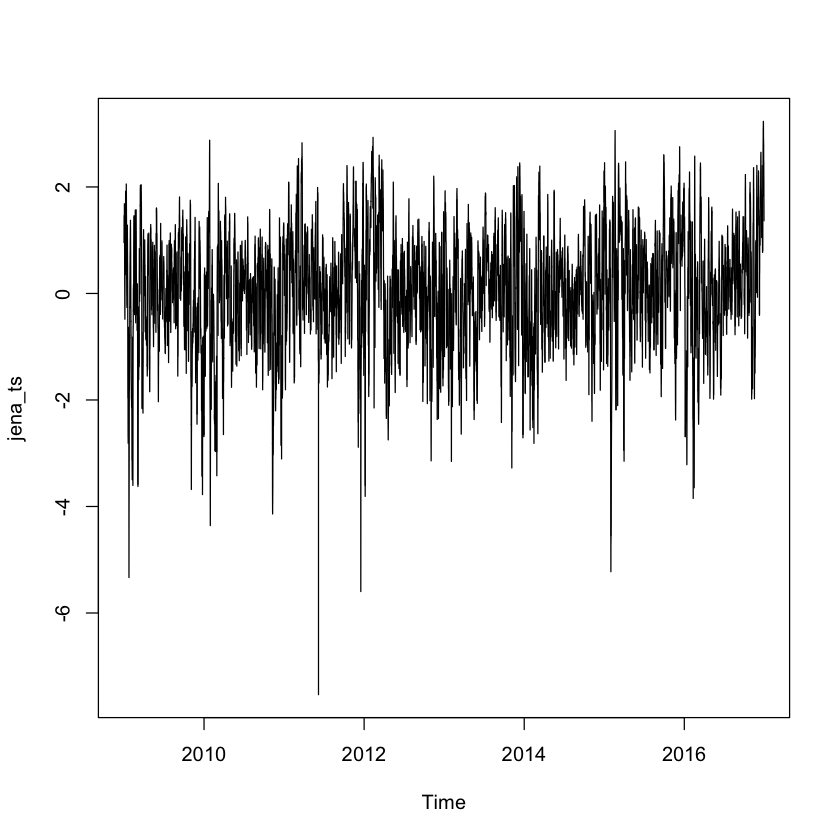

In [6]:
# Create time series from hourly aggregated data
# Frequency = 365.25 for daily data, but since we have hourly data, frequency = 24*365.25 = 8766
# However, for SARIMA with yearly seasonality on hourly data, we use frequency = 8766
# But if we want daily seasonality, frequency = 24 (hours per day)
# For yearly seasonality with hourly data: frequency = 24 * 365.25 = 8766
jena_ts = ts(df_hourly$`X0`, start = c(2009, 1, 1), frequency = 24*365.25)
plot(jena_ts)


In [7]:
# check for stationarity
adf.test(jena_ts)

Warning message in adf.test(jena_ts):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  jena_ts
Dickey-Fuller = -18.995, Lag order = 41, p-value = 0.01
alternative hypothesis: stationary


The $p$-value is very tiny, which indicates strong evidence against the null-hypothesis of non-stationarity

This function is used to automatically select the best ARIMA or Seasonal ARIMA (SARIMA) model for a given time series.

In [ ]:
best_sarima <- auto.arima(jena_ts, d=0, seasonal=TRUE, stepwise=FALSE, approximation=TRUE)

In [ ]:
summary(best_sarima)

Series: jena_ts 
ARIMA(0,0,5) with non-zero mean 

Coefficients:
         ma1     ma2     ma3     ma4     ma5    mean
      2.7916  4.1986  3.9248  2.2367  0.6845  0.0674
s.e.  0.0017  0.0033  0.0032  0.0020  0.0010  0.0019

sigma^2 = 0.006882:  log likelihood = 450190.9
AIC=-900367.8   AICc=-900367.8   BIC=-900291.2

Training set error measures:
                        ME       RMSE        MAE      MPE     MAPE       MASE
Training set -2.226594e-06 0.08295722 0.05710527 5.881944 19.50957 0.06806611
                  ACF1
Training set 0.4679916

Coefficients
MA(1): 2.7916

MA(2): 4.1986

MA(3): 3.9248

MA(4): 2.2367

MA(5): 0.6845

Mean: 0.0674

Standard errors for coefficients are all very small, indicating stable estimates.

Model Diagnostics
Estimated error variance (
σ
2
σ 
2
 ): 0.006882

Log likelihood: 450190.9

Information criteria:

AIC: -900367.8

AICc: -900367.8

BIC: -900291.2

Lower values for AIC/BIC indicate better model fit.

Training Set Error Measures
ME (Mean Error): -2.23e-06

RMSE (Root Mean Squared Error): 0.08295722

MAE (Mean Absolute Error): 0.05710527

MPE (Mean Percentage Error): 5.881944

MAPE (Mean Absolute Percentage Error): 19.50957

MASE (Mean Absolute Scaled Error): 0.06806611

Residual autocorrelation (ACF1): 0.4679916

ACF1 below 0.5 is generally acceptable; residuals look moderately uncorrelated.

N

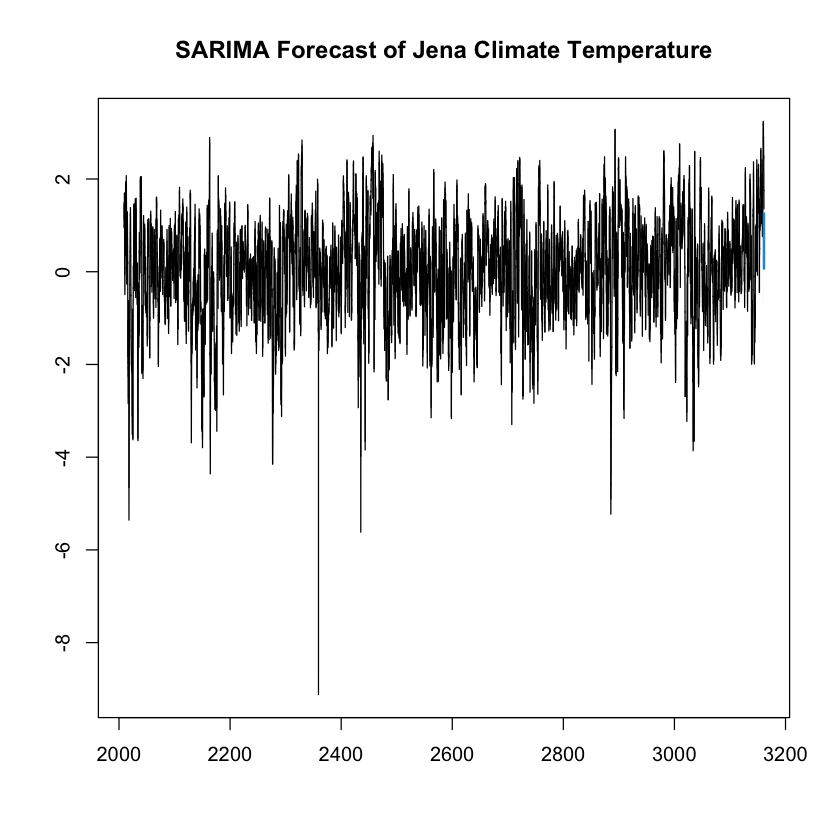

In [ ]:
forecasted <- forecast(best_sarima, h=30)
plot(forecasted, main="SARIMA Forecast of Jena Climate Temperature")

We can also check the residual diagnostics.


	Ljung-Box test

data:  Residuals from ARIMA(0,0,5) with non-zero mean
Q* = 42915831, df = 725, p-value < 2.2e-16

Model df: 5.   Total lags used: 730



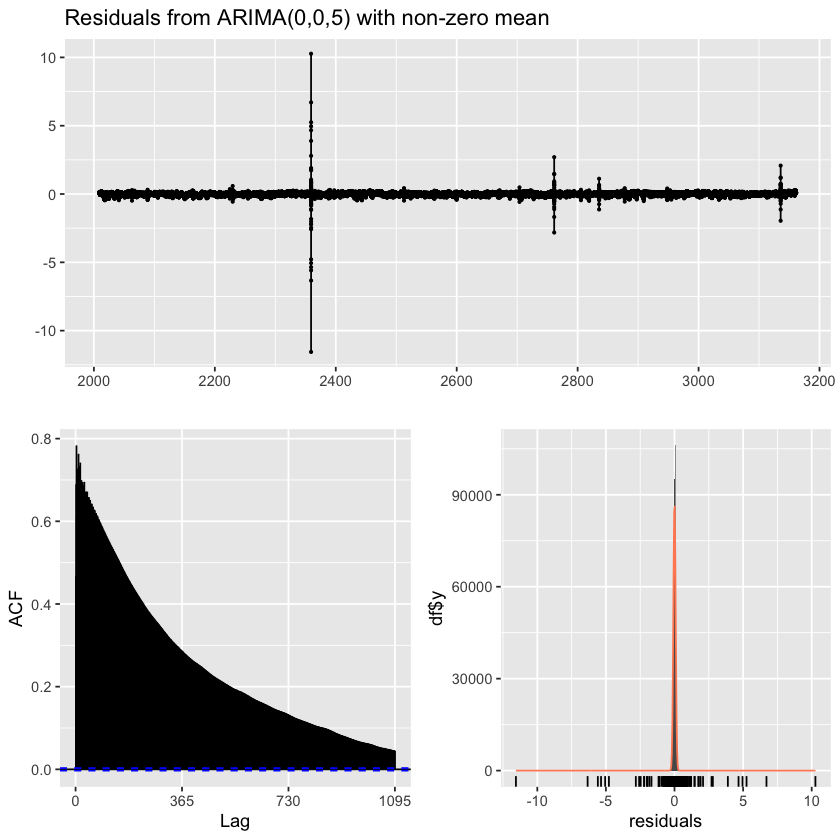

In [ ]:
checkresiduals(best_sarima)